# Business Understanding
## Problem Statement
The University of Zambia (UNZA) hosts a growing repository of academic journal articles across multiple disciplines. However, these articles are not systematically categorized according to Zambia’s Vision 2030 development sectors. This lack of alignment presents a missed opportunity to leverage UNZA’s intellectual output for national strategic planning, policy formulation, and sectoral development monitoring.

This project aims to develop a data-driven classification system that maps UNZA journal articles to the appropriate Vision 2030 sectors using machine learning techniques. By automating this classification, we intend to bridge the gap between academic research and national development priorities, enabling policymakers, researchers, and institutions to better identify and track sectoral contributions and trends.

## Objectives
**1. To align the University of Zambia’s research with national priorities:**
Systematically map academic journal articles to Zambia’s Vision 2030 development sectors to highlight how the UNZA’s intellectual output contributes to achieving national development goals.

**2. To enable evidence-based decision-making:**
Provide policymakers, researchers, and development stakeholders with an accessible, data-driven tool for identifying sectoral trends and gaps in research, thereby supporting targeted policy formulation and strategic resource allocation.

**3. To automate and scale research classification:**
Develop a machine learning–powered system to classify and update the categorization of research articles efficiently, ensuring scalability as UNZA’s repository grows and enabling continuous monitoring of sectoral contributions over time.

## Data Mining Goals

**1. Design a supervised multi-class classification model** to assign each UNZA journal article to one of Zambia’s Vision 2030 sectors based on the article’s metadata (title, abstract, and keywords).

*Purpose*: Reveal the alignment between academic output and national development areas.

*Method*: Use labeled training data mapped to Vision 2030 sectors, extracted from a subset of articles.

**Expected Output**: Accurate labels such as “Education,” “Agriculture,” “Health,” “Infrastructure”, etc.

**2. Identify latent research clusters and anomalies** through unsupervised learning (e.g., clustering or topic modeling) to uncover emerging themes or neglected areas.

*Purpose*: Help decision-makers identify new or missing areas of national interest not currently emphasized in the Vision 2030 framework.

*Method*: Apply techniques like K-Means, DBSCAN, or LDA topic modeling on text embeddings.

**Expected Output**: Visual or descriptive reports of discovered themes or outliers.

**3. Deploy a scalable, retrainable classification pipeline** using modern ML techniques and modular design.

*Purpose*: Automate the tagging process for future UNZA research uploads.

*Method*: Build a modular pipeline for preprocessing, vectorization (e.g., TF-IDF or BERT), training, evaluation, and inference.

**Expected Output**: A script or web app that classifies new articles on upload.

**4. Continuously evaluate model performance** over time using metrics such as F1-score, accuracy, and confusion matrices.

*Purpose*: Ensure system reliability and adaptiveness as language and research topics evolve.

*Method*: Establish a validation framework and regularly benchmark models.

**Expected Output**: Monitoring logs or retraining criteria to prevent model drift.

## Initial Project Success Criteria

The project will be considered initially successful if the supervised classification model achieves at least 60% accuracy in assigning UNZA journal articles to the correct Zambia Vision 2030 development sectors.

This baseline is realistic for a first iteration, considering:

Data quality issues such as incomplete or inconsistent titles, abstracts, or keywords.

Sector overlap, where some research spans multiple development areas.

Model maturity, as this is the initial deployment and will improve with further training and tuning.

Achieving this baseline will:

Demonstrate that the model performs significantly above random guessing.

Provide policymakers and researchers with a usable starting point for tracking sectoral research contributions.

Establish a functional foundation for refining the system toward higher accuracy and more adoption.

# Data Understanding

In [5]:
# --- Step 1: Import libraries ---
import pandas as pd
import matplotlib.pyplot as plt
# --- Step 2: Load dataset ---
file_path = "../data/vision2030_corpus.csv"
df = pd.read_csv(file_path)
# --- Step 3: Initial Exploration ---
print("First 5 rows:")
display(df.head())

First 5 rows:


,source,id,doi,title,abstract,authors,published,pdf_url,topics,journal,assigned_sectors,provenance_sources,query_sector
0,openalex,https://openalex.org/W2130222293,https://doi.org/10.1093/occmed/52.6.311,"Pesticide sprayers' knowledge, attitude and pr...",Pesticide sprayers from five state‐owned agric...,NaN,2002-09-01,https://academic.oup.com/occmed/article-pdf/52...,Pesticide Exposure and Toxicity;Insect and Pes...,NaN,Agriculture,openalex,Agriculture
1,openalex,https://openalex.org/W2765377880,https://doi.org/10.1016/j.agsy.2017.09.007,"Climate smart agriculture, farm household typo...",One of the great challenges in agricultural de...,NaN,2017-11-01,NaN,Agricultural risk and resilience,NaN,Agriculture,openalex,Agriculture
2,openalex,https://openalex.org/W2808245019,https://doi.org/10.1073/pnas.1806645115,"Policy distortions, farm size, and the overuse...",Significance Overuse of agricultural chemicals...,NaN,2018-06-18,https://www.pnas.org/content/pnas/115/27/7010....,Agriculture Sustainability and Environmental I...,NaN,Agriculture,openalex,Agriculture
3,openalex,https://openalex.org/W2171347306,https://doi.org/10.5860/choice.31-2759,"Smallholders, householders: farm families and ...",Contrasting the prevailing theories of the evo...,NaN,1994-01-01,NaN,"Agriculture, Land Use, Rural Development;Agric...",NaN,Agriculture,openalex,Agriculture
4,openalex,https://openalex.org/W2888829139,https://doi.org/10.1016/j.landusepol.2018.08.021,Land fragmentation and other determinants of a...,NaN,NaN,2018-08-29,NaN,Economic Growth and Productivity;Land Rights a...,NaN,Agriculture,openalex,Agriculture


The code above loads the dataset into our colaborotory notebook

In [ ]:
# --- Step 4: Summary statistics ---
print("\nInfo:")
df.info()



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17136 entries, 0 to 17135
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              17136 non-null  object
 1   id                  17136 non-null  object
 2   doi                 12312 non-null  object
 3   title               17135 non-null  object
 4   abstract            13509 non-null  object
 5   authors             3196 non-null   object
 6   published           17136 non-null  object
 7   pdf_url             7526 non-null   object
 8   topics              13903 non-null  object
 9   journal             3196 non-null   object
 10  assigned_sectors    17136 non-null  object
 11  provenance_sources  17136 non-null  object
 12  query_sector        17136 non-null  object
dtypes: object(13)
memory usage: 1.7+ MB


Dataset has 17,136 rows × 13 columns.
All columns are stored as object/text.
Missing values appear mainly in authors, abstract, doi, pdf_url, and journal.
Titles and abstracts differ in length, showing variation in metadata.

In [ ]:

print("\nSummary statistics (all columns):")
display(df.describe(include="all"))


Summary statistics (all columns):


,source,id,doi,title,abstract,authors,published,pdf_url,topics,journal,assigned_sectors,provenance_sources,query_sector
count,17136,17136,12312,17135,13509,3196,17136,7526,13903,3196,17136,17136,17136
unique,2,17136,12312,16926,13447,3126,8211,7473,10295,1,26,2,14
top,openalex,https://openalex.org/W2130222293,https://doi.org/10.1093/occmed/52.6.311,"The Nature of the Farm: Contracts, Risk, and O...",Our website uses cookies to enhance your exper...,Brian P. Hanley,2020-01-01,https://pq-static-content.proquest.com/collate...,Child Nutrition and Water Access,arXiv,Mining,openalex,Mining
freq,13940,1,1,3,12,5,121,4,95,3196,1249,13940,1250


The code above generates descriptive statistics for both numeric and categorical columns.

In [4]:
print("\nShape (rows, columns):", df.shape)

print("\nMissing values per column:")
print(df.isnull().sum())


Shape (rows, columns): (17136, 13)

Missing values per column:
source                    0
id                        0
doi                    4824
title                     1
abstract               3627
authors               13940
published                 0
pdf_url                9610
topics                 3233
journal               13940
assigned_sectors          0
provenance_sources        0
query_sector              0
dtype: int64


The code above first prints the dataset’s overall dimensions (rows and columns) using df.shape. Then it shows how many missing values each column contains by running df.isnull().sum().

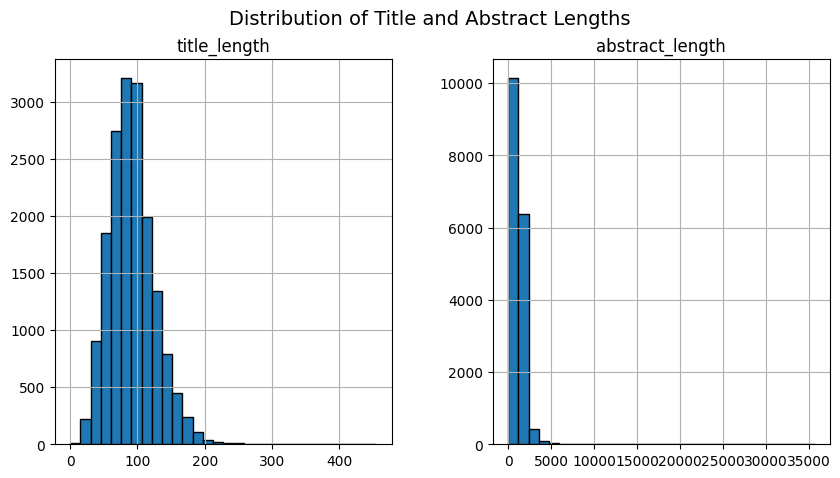

Missing data rates (%):


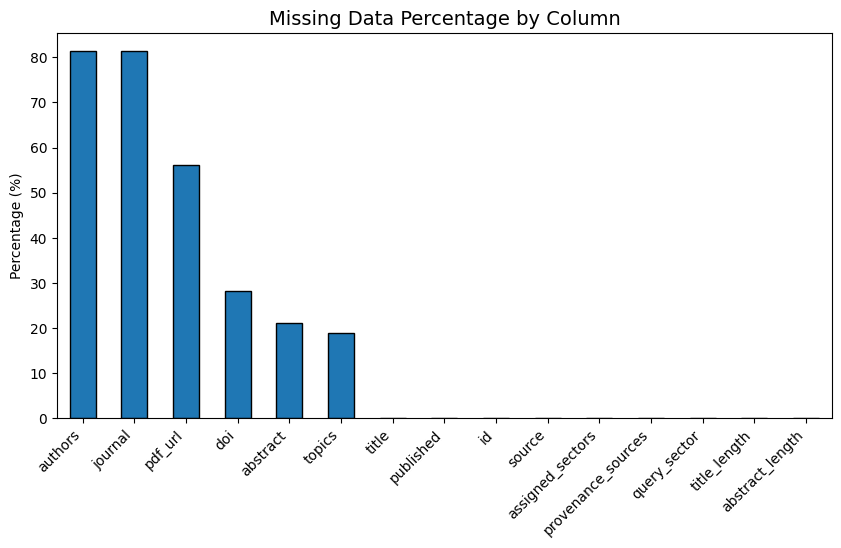

In [13]:

# --- Create derived length columns ---
df["title_length"] = df["title"].fillna("").apply(len)
df["abstract_length"] = df["abstract"].fillna("").apply(len)

# --- Plot histograms ---
df[["title_length", "abstract_length"]].hist(
    figsize=(10, 5), bins=30, edgecolor="black"
)
plt.suptitle("Distribution of Title and Abstract Lengths", fontsize=14)
plt.show()

# Missing rate per column (in %)
missing_rates = df.isnull().mean().sort_values(ascending=False) * 100

print("Missing data rates (%):")

# Plot as bar chart
plt.figure(figsize=(10,5))
missing_rates.plot(kind="bar", edgecolor="black")
plt.title("Missing Data Percentage by Column", fontsize=14)
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, ha="right")
plt.show()


### Dataset Summary

The dataset has **17,136 rows × 13 columns** of academic publication metadata.

#### Observations

- **Data types**:  
  All columns are text. `published` should be converted to `datetime` for trend analysis.  

- **Missing data**:  
  - `authors`: 81% missing  
  - `journal`: 81% missing  
  - `abstract`: 21% missing  
  - `doi`: 28% missing  
  - `pdf_url`: 56% missing  
  - Other fields: complete  

- **Uniqueness**:  
  - `id` is unique (usable as primary key)  
  - Titles are mostly unique (99%)  

- **Distributions**:  
  - `source` dominated by **openalex** (81%)  
  - `assigned_sectors` has 26 categories, with **Mining** and **Agriculture** frequent  
  - Publication years span **1994–2020+**  

#### Interpretation

The dataset is **large and well-structured**, but metadata gaps (authors, journals, abstracts) limit certain analyses.  
Strong identifiers (`id`, `topics`, `assigned_sectors`) support sectoral and thematic exploration.  
Preprocessing (handling missingness, normalizing dates) is needed for deeper analysis.
